# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [5]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

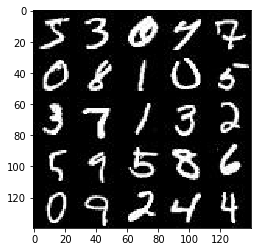

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

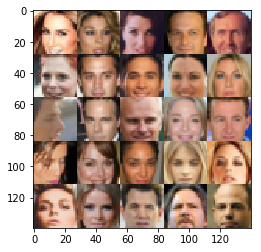

In [7]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


c:\users\dnastri\appdata\local\continuum\anaconda3\envs\tensorflow1_1\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [9]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels))
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape=())

    return input_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [10]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        relu1 = tf.maximum(alpha * x1, x1)
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [11]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse= not is_train):
        alpha = 0.2
        strt = 7
        st_filt = 512 
        x1 = tf.layers.dense(z, strt*strt*st_filt)
        x1 = tf.reshape(x1, (-1, strt, strt, st_filt))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [12]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    d_out_real,d_logits_real = discriminator(input_real, False)
    g_model = generator(input_z, out_channel_dim)
    d_out_fake,d_logits_fake = discriminator(g_model, True)
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_logits_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_logits_fake)))    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    b,x,y,c=data_shape
    input_real, input_z, _ = model_inputs(x, y, c, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, c)
    d_train_opt , g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            ii = 0
            for batch_images in get_batches(batch_size):
                ii = ii+1
                batch_images = batch_images*2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                if ii % 10 == 0 : 
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))    
                if ii % 100 == 0 : 
                    show_generator_output(sess, 25, input_z, c, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3794... Generator Loss: 3.8062
Epoch 1/2... Discriminator Loss: 0.4225... Generator Loss: 5.1774
Epoch 1/2... Discriminator Loss: 0.3538... Generator Loss: 4.9783
Epoch 1/2... Discriminator Loss: 0.3547... Generator Loss: 5.0093
Epoch 1/2... Discriminator Loss: 0.3392... Generator Loss: 5.5445
Epoch 1/2... Discriminator Loss: 0.3378... Generator Loss: 5.4139
Epoch 1/2... Discriminator Loss: 0.3373... Generator Loss: 5.8893
Epoch 1/2... Discriminator Loss: 0.5400... Generator Loss: 3.3346
Epoch 1/2... Discriminator Loss: 2.2048... Generator Loss: 16.6353
Epoch 1/2... Discriminator Loss: 1.5913... Generator Loss: 0.9129


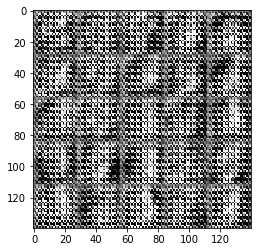

Epoch 1/2... Discriminator Loss: 0.9166... Generator Loss: 1.2343
Epoch 1/2... Discriminator Loss: 1.2151... Generator Loss: 1.8296
Epoch 1/2... Discriminator Loss: 0.8417... Generator Loss: 1.6972
Epoch 1/2... Discriminator Loss: 1.0831... Generator Loss: 1.7990
Epoch 1/2... Discriminator Loss: 1.5237... Generator Loss: 0.4769
Epoch 1/2... Discriminator Loss: 1.0697... Generator Loss: 1.3306
Epoch 1/2... Discriminator Loss: 1.2644... Generator Loss: 0.6491
Epoch 1/2... Discriminator Loss: 1.2577... Generator Loss: 1.8204
Epoch 1/2... Discriminator Loss: 1.2669... Generator Loss: 1.8900
Epoch 1/2... Discriminator Loss: 1.0889... Generator Loss: 1.1494


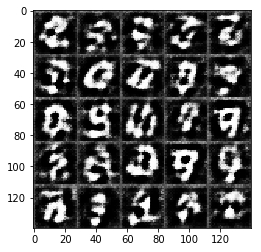

Epoch 1/2... Discriminator Loss: 1.7198... Generator Loss: 3.9337
Epoch 1/2... Discriminator Loss: 0.8904... Generator Loss: 1.3959
Epoch 1/2... Discriminator Loss: 1.0666... Generator Loss: 0.7796
Epoch 1/2... Discriminator Loss: 1.0609... Generator Loss: 0.9335
Epoch 1/2... Discriminator Loss: 1.1434... Generator Loss: 1.2496
Epoch 1/2... Discriminator Loss: 1.2841... Generator Loss: 0.7522
Epoch 1/2... Discriminator Loss: 1.0157... Generator Loss: 0.9613
Epoch 1/2... Discriminator Loss: 1.2369... Generator Loss: 0.7201
Epoch 1/2... Discriminator Loss: 1.1321... Generator Loss: 1.0919
Epoch 1/2... Discriminator Loss: 0.9855... Generator Loss: 1.0658


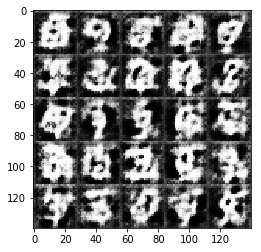

Epoch 1/2... Discriminator Loss: 0.9873... Generator Loss: 1.7575
Epoch 1/2... Discriminator Loss: 1.1450... Generator Loss: 0.7987
Epoch 1/2... Discriminator Loss: 0.9139... Generator Loss: 1.2627
Epoch 1/2... Discriminator Loss: 0.8842... Generator Loss: 1.1683
Epoch 1/2... Discriminator Loss: 0.9745... Generator Loss: 1.5685
Epoch 1/2... Discriminator Loss: 1.1416... Generator Loss: 0.7402
Epoch 1/2... Discriminator Loss: 1.5172... Generator Loss: 0.4874
Epoch 1/2... Discriminator Loss: 0.9758... Generator Loss: 1.0332
Epoch 1/2... Discriminator Loss: 1.1961... Generator Loss: 0.7814
Epoch 1/2... Discriminator Loss: 1.2105... Generator Loss: 0.9351


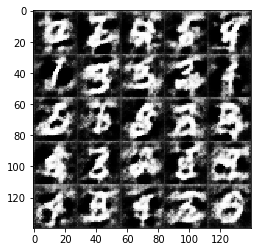

Epoch 1/2... Discriminator Loss: 0.9731... Generator Loss: 1.4597
Epoch 1/2... Discriminator Loss: 1.1328... Generator Loss: 1.1601
Epoch 1/2... Discriminator Loss: 1.2542... Generator Loss: 1.2449
Epoch 1/2... Discriminator Loss: 1.1046... Generator Loss: 1.1484
Epoch 1/2... Discriminator Loss: 0.9752... Generator Loss: 1.1580
Epoch 1/2... Discriminator Loss: 1.1343... Generator Loss: 0.9446
Epoch 1/2... Discriminator Loss: 1.1805... Generator Loss: 0.7482
Epoch 1/2... Discriminator Loss: 1.2133... Generator Loss: 0.7299
Epoch 1/2... Discriminator Loss: 1.2342... Generator Loss: 1.1900
Epoch 1/2... Discriminator Loss: 1.1533... Generator Loss: 0.8038


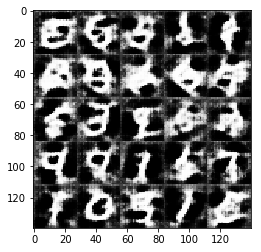

Epoch 1/2... Discriminator Loss: 1.3682... Generator Loss: 0.6391
Epoch 1/2... Discriminator Loss: 1.2946... Generator Loss: 0.5843
Epoch 1/2... Discriminator Loss: 1.3121... Generator Loss: 1.5932
Epoch 1/2... Discriminator Loss: 1.1607... Generator Loss: 0.9011
Epoch 1/2... Discriminator Loss: 1.6893... Generator Loss: 0.4183
Epoch 1/2... Discriminator Loss: 1.2731... Generator Loss: 0.6655
Epoch 1/2... Discriminator Loss: 1.3008... Generator Loss: 0.6702
Epoch 1/2... Discriminator Loss: 1.1147... Generator Loss: 0.8215
Epoch 1/2... Discriminator Loss: 1.1036... Generator Loss: 1.0464
Epoch 1/2... Discriminator Loss: 1.1515... Generator Loss: 0.7802


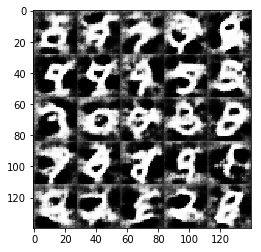

Epoch 1/2... Discriminator Loss: 1.0950... Generator Loss: 1.4846
Epoch 1/2... Discriminator Loss: 1.0464... Generator Loss: 1.0817
Epoch 1/2... Discriminator Loss: 1.1793... Generator Loss: 0.8679
Epoch 1/2... Discriminator Loss: 1.0384... Generator Loss: 1.1252
Epoch 1/2... Discriminator Loss: 1.3690... Generator Loss: 1.9589
Epoch 1/2... Discriminator Loss: 1.2372... Generator Loss: 0.7382
Epoch 1/2... Discriminator Loss: 1.0413... Generator Loss: 1.2282
Epoch 1/2... Discriminator Loss: 1.6035... Generator Loss: 0.4322
Epoch 1/2... Discriminator Loss: 1.1543... Generator Loss: 0.7563
Epoch 1/2... Discriminator Loss: 1.1876... Generator Loss: 1.3321


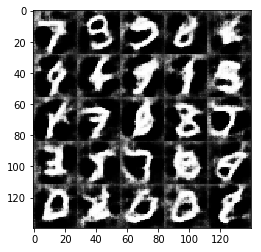

Epoch 1/2... Discriminator Loss: 1.2752... Generator Loss: 0.7263
Epoch 1/2... Discriminator Loss: 1.2214... Generator Loss: 0.9364
Epoch 1/2... Discriminator Loss: 1.2639... Generator Loss: 1.8817
Epoch 1/2... Discriminator Loss: 0.9846... Generator Loss: 1.5675
Epoch 1/2... Discriminator Loss: 1.0944... Generator Loss: 0.9469
Epoch 1/2... Discriminator Loss: 1.2072... Generator Loss: 0.6767
Epoch 1/2... Discriminator Loss: 1.2104... Generator Loss: 0.7510
Epoch 1/2... Discriminator Loss: 1.1002... Generator Loss: 0.9956
Epoch 1/2... Discriminator Loss: 1.1913... Generator Loss: 1.0015
Epoch 1/2... Discriminator Loss: 1.4708... Generator Loss: 0.5005


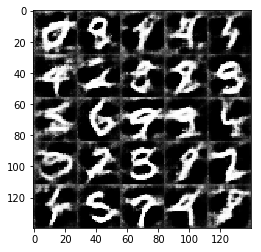

Epoch 1/2... Discriminator Loss: 1.0317... Generator Loss: 1.2377
Epoch 1/2... Discriminator Loss: 1.0930... Generator Loss: 0.8492
Epoch 1/2... Discriminator Loss: 1.1508... Generator Loss: 0.7911
Epoch 1/2... Discriminator Loss: 0.8993... Generator Loss: 2.1258
Epoch 1/2... Discriminator Loss: 0.9024... Generator Loss: 1.2402
Epoch 1/2... Discriminator Loss: 2.0053... Generator Loss: 0.3154
Epoch 1/2... Discriminator Loss: 1.1823... Generator Loss: 1.0106
Epoch 1/2... Discriminator Loss: 0.9832... Generator Loss: 1.2923
Epoch 1/2... Discriminator Loss: 1.0020... Generator Loss: 1.1790
Epoch 1/2... Discriminator Loss: 1.0398... Generator Loss: 0.9578


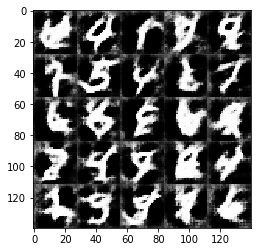

Epoch 1/2... Discriminator Loss: 1.1738... Generator Loss: 0.7569
Epoch 1/2... Discriminator Loss: 0.9915... Generator Loss: 1.0361
Epoch 1/2... Discriminator Loss: 1.0381... Generator Loss: 1.0623
Epoch 2/2... Discriminator Loss: 1.1672... Generator Loss: 0.7078
Epoch 2/2... Discriminator Loss: 1.1822... Generator Loss: 0.7473
Epoch 2/2... Discriminator Loss: 1.1406... Generator Loss: 1.0217
Epoch 2/2... Discriminator Loss: 3.4719... Generator Loss: 4.4684
Epoch 2/2... Discriminator Loss: 1.2019... Generator Loss: 0.8895
Epoch 2/2... Discriminator Loss: 1.2221... Generator Loss: 0.6785
Epoch 2/2... Discriminator Loss: 1.0157... Generator Loss: 0.9918
Epoch 2/2... Discriminator Loss: 1.1337... Generator Loss: 0.7803
Epoch 2/2... Discriminator Loss: 0.9206... Generator Loss: 1.4298
Epoch 2/2... Discriminator Loss: 1.2773... Generator Loss: 0.6377


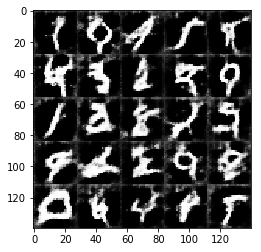

Epoch 2/2... Discriminator Loss: 1.0443... Generator Loss: 0.9093
Epoch 2/2... Discriminator Loss: 2.1193... Generator Loss: 0.2745
Epoch 2/2... Discriminator Loss: 0.9721... Generator Loss: 1.1431
Epoch 2/2... Discriminator Loss: 0.9764... Generator Loss: 1.0522
Epoch 2/2... Discriminator Loss: 1.4412... Generator Loss: 0.4961
Epoch 2/2... Discriminator Loss: 1.0881... Generator Loss: 0.7793
Epoch 2/2... Discriminator Loss: 1.5091... Generator Loss: 2.1283
Epoch 2/2... Discriminator Loss: 1.0808... Generator Loss: 1.0465
Epoch 2/2... Discriminator Loss: 1.0339... Generator Loss: 0.8711
Epoch 2/2... Discriminator Loss: 1.1463... Generator Loss: 2.5946


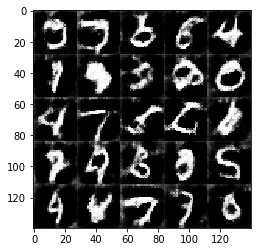

Epoch 2/2... Discriminator Loss: 0.9460... Generator Loss: 1.0939
Epoch 2/2... Discriminator Loss: 0.9919... Generator Loss: 1.5497
Epoch 2/2... Discriminator Loss: 1.1811... Generator Loss: 0.7359
Epoch 2/2... Discriminator Loss: 1.3960... Generator Loss: 0.5232
Epoch 2/2... Discriminator Loss: 0.8830... Generator Loss: 1.0555
Epoch 2/2... Discriminator Loss: 1.3354... Generator Loss: 0.6524
Epoch 2/2... Discriminator Loss: 1.3004... Generator Loss: 1.5048
Epoch 2/2... Discriminator Loss: 1.3151... Generator Loss: 0.6135
Epoch 2/2... Discriminator Loss: 1.0756... Generator Loss: 1.0832
Epoch 2/2... Discriminator Loss: 1.0987... Generator Loss: 0.9884


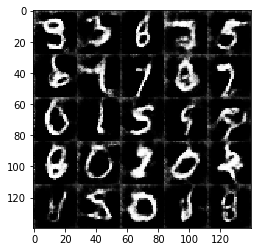

Epoch 2/2... Discriminator Loss: 1.1227... Generator Loss: 1.7490
Epoch 2/2... Discriminator Loss: 1.3759... Generator Loss: 0.5794
Epoch 2/2... Discriminator Loss: 0.9132... Generator Loss: 1.5174
Epoch 2/2... Discriminator Loss: 1.0548... Generator Loss: 1.4025
Epoch 2/2... Discriminator Loss: 0.9420... Generator Loss: 2.0065
Epoch 2/2... Discriminator Loss: 1.0571... Generator Loss: 0.9234
Epoch 2/2... Discriminator Loss: 1.1921... Generator Loss: 0.6776
Epoch 2/2... Discriminator Loss: 0.8455... Generator Loss: 1.3393
Epoch 2/2... Discriminator Loss: 0.9693... Generator Loss: 1.1567
Epoch 2/2... Discriminator Loss: 0.9631... Generator Loss: 0.9837


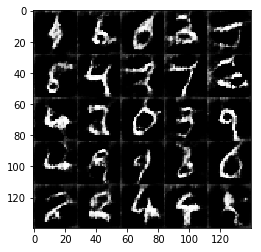

Epoch 2/2... Discriminator Loss: 1.0185... Generator Loss: 2.3126
Epoch 2/2... Discriminator Loss: 1.2139... Generator Loss: 0.8381
Epoch 2/2... Discriminator Loss: 1.2382... Generator Loss: 0.7501
Epoch 2/2... Discriminator Loss: 0.8731... Generator Loss: 1.3941
Epoch 2/2... Discriminator Loss: 1.0233... Generator Loss: 1.8981
Epoch 2/2... Discriminator Loss: 1.1175... Generator Loss: 0.7546
Epoch 2/2... Discriminator Loss: 1.3264... Generator Loss: 0.6309
Epoch 2/2... Discriminator Loss: 1.0038... Generator Loss: 1.1899
Epoch 2/2... Discriminator Loss: 1.1861... Generator Loss: 1.8445
Epoch 2/2... Discriminator Loss: 0.9025... Generator Loss: 1.1365


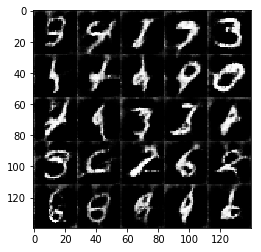

Epoch 2/2... Discriminator Loss: 1.3048... Generator Loss: 1.4540
Epoch 2/2... Discriminator Loss: 0.9819... Generator Loss: 1.3140
Epoch 2/2... Discriminator Loss: 0.9414... Generator Loss: 1.7151
Epoch 2/2... Discriminator Loss: 1.0882... Generator Loss: 0.9397
Epoch 2/2... Discriminator Loss: 0.8256... Generator Loss: 1.3735
Epoch 2/2... Discriminator Loss: 1.1144... Generator Loss: 0.7988
Epoch 2/2... Discriminator Loss: 1.5177... Generator Loss: 0.4981
Epoch 2/2... Discriminator Loss: 1.1668... Generator Loss: 0.7909
Epoch 2/2... Discriminator Loss: 1.3770... Generator Loss: 0.5284
Epoch 2/2... Discriminator Loss: 1.0898... Generator Loss: 0.7394


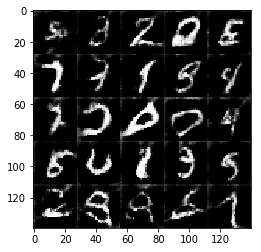

Epoch 2/2... Discriminator Loss: 1.4733... Generator Loss: 0.4806
Epoch 2/2... Discriminator Loss: 1.0753... Generator Loss: 1.2189
Epoch 2/2... Discriminator Loss: 1.2030... Generator Loss: 0.7764
Epoch 2/2... Discriminator Loss: 0.8796... Generator Loss: 1.5265


In [ ]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.